## Cleaning

In [1]:
%run './lib/libraries.ipynb'

dython              0.6.1
tinydb              4.2.0


In [2]:
dfClean  = load_df('dfFlt')

###### Remove variables assignment_late_submission, is_manual_scoring_required and is_deleted
Do this early so they don't get in the way

In [ ]:
dfClean = dfClean.drop('assignment_late_submission', 'is_manual_scoring_required', 'is_deleted')

In [ ]:
finish_todo('Remove variables assignment_late_submission, is_manual_scoring_required and is_deleted')

###### Remove unary learner_attempt_status
Do this early so they don't get in the way

In [ ]:
dfClean = dfClean.drop('learner_attempt_status')

In [ ]:
finish_todo('Remove unary learner_attempt_status = "fully scored"')



###### Remove 1566 [unassigned] in response_correctness observations"

In [ ]:
# Make sure to preserve the nulls
dfFlt = remove_1566_unassigned()

###### Remove unary variables assignment_attempt_number and assignment_max_attempts
After 1566 unassigned in response_correctness is address, assignment_attempt_number and assignment_max_attemps is unary

In [ ]:
dfClean = dfClean.drop("assignment_attempt_number", "assignment_max_attempts")


In [ ]:
finish_todo("Remove 1566 [unassigned] in response_correctness")
finish_todo('Remove assignment_attempt_number and assignment_max_attempts')


###### Remove response_correctness

In [ ]:
dfClean = dfClean.drop('response_correctness')

In [ ]:
finish_todo('Remove 3298 null values in response_correctness')


### Reclassify categories in item_type_code_name

In [10]:
# Before Categories
dfClean.select("item_type_code_name").distinct().orderBy("item_type_code_name").show(50, False)


+----------------------+
item_type_code_name |
+----------------------+
null |
FillinBlankResponse |
MultipleChoiceResponse|
RubricResponse |
aheAlgo |
bucketing |
choiceMatrix |
cloze |
equationEntry |
essay |
fileUpload |
fillInTheBlank |
graphing |
imageLabel |
matching |
multipleChoice |
multipleSelect |
numberLine |
selectText |
shortAnswer |
sortable |
trueFalse |
+----------------------+

Combine Suffix Levels
- The levels with the suffix Response (ex: FillinBlankResponse) is the same type of question as level without the suffix (ex: fillInTheBlank)

In [12]:
# Combine fillInTheBlank and FillinBlankResponse 
dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name") == "FillinBlankResponse", "fillInTheBlank" ).otherwise(col("item_type_code_name")) )

# Combine multipleChoice and MultipleChoiceResponse 
dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name") == "MultipleChoiceResponse", "multipleChoice" ).otherwise(col("item_type_code_name")) )


In [13]:
from pyspark.sql.functions import col, round

tot = dfClean.filter(col("item_type_code_name").isNull() == False).count()

freqTable = dfClean.groupBy("item_type_code_name") \
               .count() \
               .withColumnRenamed('count', 'cnt_per_group') \
               .withColumn('perc_of_count_total', ( col('cnt_per_group') / tot) * 100 ) \
               .orderBy("cnt_per_group", ascending=False)

freqTable.show(50, False)

+-------------------+-------------+--------------------+
item_type_code_name|cnt_per_group|perc_of_count_total |
+-------------------+-------------+--------------------+
multipleChoice |34001 |43.99487604161275 |
fillInTheBlank |12077 |15.626779152217793 |
equationEntry |9516 |12.313027276020911 |
trueFalse |4963 |6.421769059572485 |
cloze |3576 |4.627089695150355 |
null |3264 |4.223383882821801 |
multipleSelect |2691 |3.481962631333782 |
graphing |2415 |3.1248382588892913 |
choiceMatrix |1336 |1.7286889912530408 |
matching |1164 |1.5061332229180686 |
bucketing |1051 |1.3599192588375342 |
selectText |1025 |1.3262771078101547 |
essay |1000 |1.2939288856684437 |
shortAnswer |983 |1.27193209461208 |
sortable |644 |0.8332902023704778 |
numberLine |455 |0.5887376429791419 |
aheAlgo |219 |0.2833704259613891 |
imageLabel |108 |0.13974431965219192 |
fileUpload |49 |0.06340251539775374 |
RubricResponse |11 |0.014233217742352882|
+-------------------+-------------+--------------------+

We only want five levels, so convert everything below 6% to other

In [15]:
otherRows    = freqTable.filter("perc_of_count_total < 6")
otherLevels  = [row['item_type_code_name'] for row in otherRows.select("item_type_code_name").collect()]

dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name").isin(otherLevels) | col("item_type_code_name").isNull() , "Other" ).otherwise(col("item_type_code_name")) )

# Display new values
dfClean.groupBy("item_type_code_name").count().orderBy("count", ascending=False).show(50, False)


+-------------------+-----+
item_type_code_name|count|
+-------------------+-----+
multipleChoice |34001|
Other |19991|
fillInTheBlank |12077|
equationEntry |9516 |
trueFalse |4963 |
+-------------------+-----+

In [16]:
dfClean.createOrReplaceTempView("clean_data")

In [17]:
dfDesc.select('field').show(40, False)

+---------------------------------+
field |
+---------------------------------+
assessment_id |
assessment_instance_attempt_id |
assessment_instance_id |
assessment_item_response_id |
assigned_item_status |
assignment_attempt_number |
assignment_due_date |
assignment_final_submission_date |
assignment_late_submission |
assignment_max_attempts |
assignment_start_date |
ced_assignment_type_code |
final_score_unweighted |
is_affecting_grade |
is_deleted |
is_force_scored |
is_manual_scoring_required |
item_is_offline_scored |
item_type_code_name |
learner_assigned_item_attempt_id |
learner_assignment_attempt_id |
learner_attempt_status |
learner_id |
max_student_stop_datetime |
min_student_start_datetime |
number_of_distinct_instance_items|
number_of_learners |
org_id |
points_possible_unweighted |
response_correctness |
scored_datetime |
scoring_type_code |
section_id |
student_start_datetime |
student_stop_datetime |
was_fully_scored_datetime |
was_in_progress_datetime |
was_submitted_datetime_actual |
+---------------------------------+

### Reclassify categories in item_type_code_name

In [19]:
# Before Categories
dfClean.select("item_type_code_name").distinct().orderBy("item_type_code_name").show(50, False)


+----------------------+
item_type_code_name |
+----------------------+
null |
FillinBlankResponse |
MultipleChoiceResponse|
RubricResponse |
aheAlgo |
bucketing |
choiceMatrix |
cloze |
equationEntry |
essay |
fileUpload |
fillInTheBlank |
graphing |
imageLabel |
matching |
multipleChoice |
multipleSelect |
numberLine |
selectText |
shortAnswer |
sortable |
trueFalse |
+----------------------+

Combine Suffix Levels
- The levels with the suffix Response (ex: FillinBlankResponse) is the same type of question as level without the suffix (ex: fillInTheBlank)

In [21]:
# Combine fillInTheBlank and FillinBlankResponse 
dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name") == "FillinBlankResponse", "fillInTheBlank" ).otherwise(col("item_type_code_name")) )

# Combine multipleChoice and MultipleChoiceResponse 
dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name") == "MultipleChoiceResponse", "multipleChoice" ).otherwise(col("item_type_code_name")) )


In [22]:
from pyspark.sql.functions import col, round

tot = dfClean.filter(col("item_type_code_name").isNull() == False).count()

freqTable = dfClean.groupBy("item_type_code_name") \
               .count() \
               .withColumnRenamed('count', 'cnt_per_group') \
               .withColumn('perc_of_count_total', ( col('cnt_per_group') / tot) * 100 ) \
               .orderBy("cnt_per_group", ascending=False)

freqTable.show(50, False)

+-------------------+-------------+--------------------+
item_type_code_name|cnt_per_group|perc_of_count_total |
+-------------------+-------------+--------------------+
multipleChoice |34001 |43.99487604161275 |
fillInTheBlank |12077 |15.626779152217793 |
equationEntry |9516 |12.313027276020911 |
trueFalse |4963 |6.421769059572485 |
cloze |3576 |4.627089695150355 |
null |3264 |4.223383882821801 |
multipleSelect |2691 |3.481962631333782 |
graphing |2415 |3.1248382588892913 |
choiceMatrix |1336 |1.7286889912530408 |
matching |1164 |1.5061332229180686 |
bucketing |1051 |1.3599192588375342 |
selectText |1025 |1.3262771078101547 |
essay |1000 |1.2939288856684437 |
shortAnswer |983 |1.27193209461208 |
sortable |644 |0.8332902023704778 |
numberLine |455 |0.5887376429791419 |
aheAlgo |219 |0.2833704259613891 |
imageLabel |108 |0.13974431965219192 |
fileUpload |49 |0.06340251539775374 |
RubricResponse |11 |0.014233217742352882|
+-------------------+-------------+--------------------+

We only want five levels, so convert everything below 6% to other

In [24]:
otherRows    = freqTable.filter("perc_of_count_total < 6")
otherLevels  = [row['item_type_code_name'] for row in otherRows.select("item_type_code_name").collect()]

dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name").isin(otherLevels) | col("item_type_code_name").isNull() , "Other" ).otherwise(col("item_type_code_name")) )

# Display new values
dfClean.groupBy("item_type_code_name").count().orderBy("count", ascending=False).show(50, False)


+-------------------+-----+
item_type_code_name|count|
+-------------------+-----+
multipleChoice |34001|
Other |19991|
fillInTheBlank |12077|
equationEntry |9516 |
trueFalse |4963 |
+-------------------+-----+

In [25]:
dfClean.createOrReplaceTempView("clean_data")

##### Impute 749 t0 750 null dates

In [ ]:
dfImpute = impute_749_to_750_null_dates(dfFlt)

In [ ]:
date_boxplot(dfImpute, "Null Dates Fixed")

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True)

mean_hours_assignment_interval(get_random_sample(dfFlt), ax1)
ax1.set_title('All')

mean_hours_assignment_interval(dfImpute, ax2)
ax2.set_title('After')

plt.suptitle('Before and After Imputation')

plt.show()

Before and After Values Match
- student_start_datetime & scored_datetime = 9
- student_stop_datetime  & scored_datetime = -12
- was_fully_scored_datetime & scored_datetime = -17

In [ ]:
finish_todo('Impute 749 t0 750 null dates')

##### Impute 3422 null dates in scored_datetime

In [ ]:

dfImpute = impute_3422_null_dates(dfFlt)

In [ ]:
date_boxplot(dfImpute, "Null Dates Fixed")

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True)

mean_hours_assignment_interval(get_random_sample(dfFlt), ax1)
ax1.set_title('All')

mean_hours_assignment_interval(dfImpute, ax2)
ax2.set_title('After')

plt.suptitle('Before and After Imputation')

plt.show()


Before and After Values Match
- student_stop_datetime  & scored_datetime = -12

In [ ]:
finish_todo('Impute 3422 null dates in scored_datetime')

#### Impute 9965 null dates in was_in_progress_datetime


In [5]:

dfImpute = impute_9965_null_dates(dfClean)

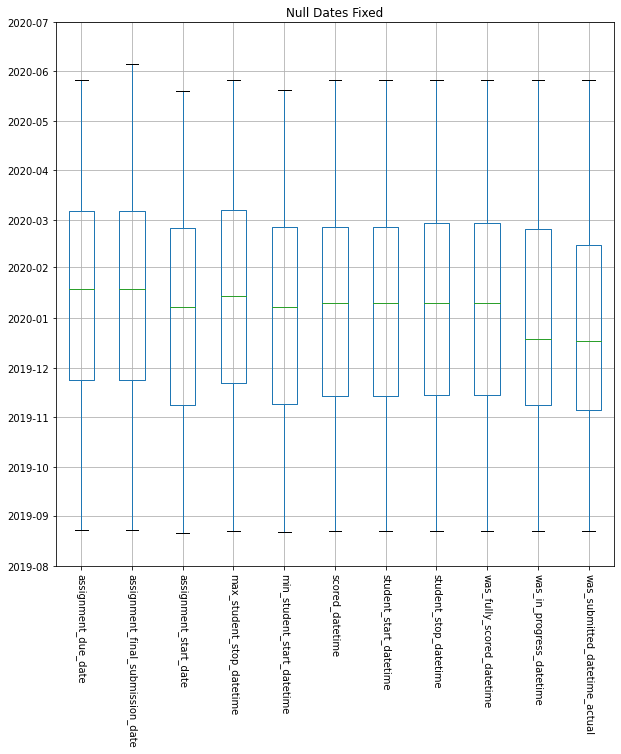

In [6]:
date_boxplot(dfImpute, "Null Dates Fixed")

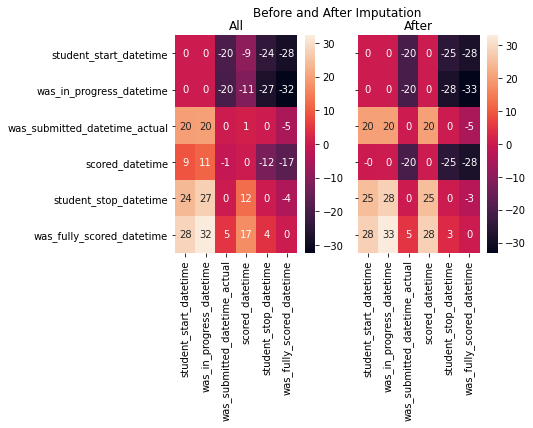

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True)

mean_hours_assignment_interval(get_random_sample(dfClean), ax1)
ax1.set_title('All')

mean_hours_assignment_interval(dfImpute, ax2)
ax2.set_title('After')

plt.suptitle('Before and After Imputation')

plt.show()


Before and After Values Match
- student_start_datetime  & was_in_progress_datetime = -12

In [ ]:
finish_todo('Impute 9965 null dates in was_in_progress_datetime')

